<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/02_baseline_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Baseline Model Evaluation

In [ ]:
!pip install -q mlflow shap lime

In [4]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import lime
from lime.lime_tabular import LimeTabularExplainer
import os

### Import Clean Data

In [5]:
processed_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FIT3199-FYP/input/01_processed_output')

In [6]:
processed_df.drop(columns=['icd_code','icd_version'], inplace=True)

### Stratified Split
- First Split (80% train + 20% test)
- Second Split (80% train, 20% validation)


In [10]:
y = processed_df["Stroke_Y/N"]
X = processed_df.drop(columns=["Stroke_Y/N"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [11]:
X

,subject_id,stay_id_x,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain,stay_id_y,seq_num,icd_title,gender,anchor_age,anchor_year,anchor_year_group,dod
0,14394983,34259230.0,7337651040,98.3,74.0,19.0,97.0,153.0,67.0,-1,70,35770203,2,369,1,46,2196,0,-9223372037
1,17730806,30258441.0,6707206680,NaN,82.0,16.0,96.0,115.0,102.0,-1,-1,35185582,1,256,1,68,2176,1,-9223372037
2,15973805,30481231.0,5538388800,98.0,109.0,18.0,98.0,113.0,77.0,-1,84,33101574,2,452,0,51,2139,1,-9223372037
3,16945691,36369419.0,4669314600,99.9,74.0,16.0,100.0,151.0,76.0,-1,77,39985497,1,158,0,81,2111,1,4693075200
4,15632719,33618002.0,6320840280,98.4,83.0,NaN,94.0,142.0,81.0,-1,-1,36271752,1,256,1,55,2170,2,6335452800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52285,15853169,33648217.0,6446541360,98.1,62.0,16.0,100.0,121.0,62.0,-1,119,33648217,2,482,0,52,2170,2,-9223372037
52286,10913302,37712176.0,7160433780,NaN,NaN,NaN,NaN,NaN,NaN,-1,92,32876218,1,203,1,25,2185,0,-9223372037
52287,11553072,31817224.0,6152949900,99.8,92.0,16.0,96.0,160.0,80.0,-1,304,37134500,1,34,1,46,2156,0,-9223372037
52288,10295929,35519857.0,5709507300,97.9,63.0,20.0,99.0,149.0,97.0,-1,-1,33921459,3,219,1,61,2141,0,-9223372037


In [ ]:
# # Save X_test and y_test
# X_test.to_csv("X_test.csv", index=False)
# y_test.to_csv("y_test.csv", index=False)

# # Save X_val and y_val
# X_val.to_csv("X_val.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

# print("Test and validation sets saved successfully.")


## Baseline Model Training

In [12]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# calculate metrics for validation set
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_accuracy = accuracy_score(y_val, y_val_pred)

# calculate metrics for test set
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Validation Metrics:")
print(f"F1 Score: {val_f1:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print()
print("Test Metrics:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

Validation Metrics:
F1 Score: 0.9999
Precision: 0.9999
Recall: 0.9999
Accuracy: 0.9999

Test Metrics:
F1 Score: 0.9975
Precision: 0.9975
Recall: 0.9975
Accuracy: 0.9975


### SHAP and LIME Analysis

#### SHAP

In [14]:
#  create a SHAP explainer and calculate SHAP values for the test set
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_test)


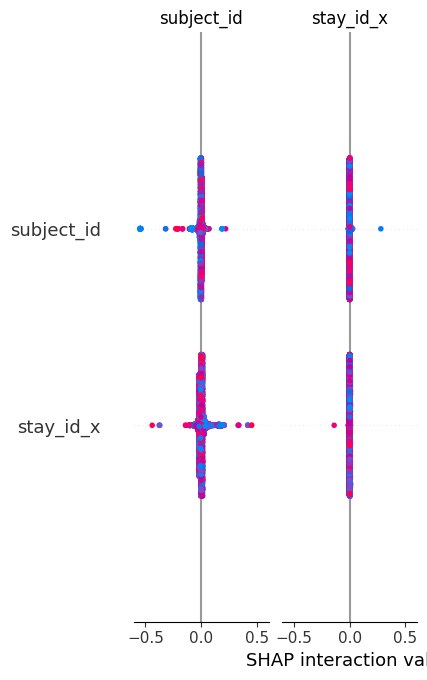

In [15]:
import shap
import matplotlib.pyplot as plt

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test)


##### Summary Plot Insights

Notes:

**Observations**


**Key Takeaway**


In [ ]:
X_test

##### Dependence Plot Insights

Notes:


**Observations**


**Key Takeaway**



#### LIME

In [ ]:
# lime_explanation = explainer_lime.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=10)
# lime_explanation.as_pyplot_figure()
# plt.show()

##### Insights
**Observations**



**Key Takeaway**


### Model Tracking With MLFlow

In [27]:
!pip install -q mlflow pyngrok

In [28]:
import mlflow
from pyngrok import ngrok

# Start MLflow tracking server
get_ipython().system_raw("mlflow server --host 0.0.0.0 --port 8081 --backend-store-uri sqlite:///mlflow.db &")

# Expose the MLflow tracking server
public_url = ngrok.connect(8081).public_url
print(f"MLflow Tracking UI: {public_url}")

# Set MLflow tracking URI
mlflow.set_tracking_uri(public_url)

# Set Experiment
mlflow.set_experiment("Stroke Prediction Experiment")


ERROR:pyngrok.process.ngrok:t=2025-03-14T02:08:58+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-03-14T02:08:58+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-03-14T02:08:58+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [ ]:
train_data = X_train.copy()
train_data['category'] = y_train

val_data = X_val.copy()
val_data['category'] = y_val

test_data = X_test.copy()
test_data['category'] = y_test

In [ ]:
train_df = mlflow.data.from_pandas(train_data, source=preprocessed_data_path)
val_df = mlflow.data.from_pandas(val_data, source=preprocessed_data_path)
test_df = mlflow.data.from_pandas(test_data, source=preprocessed_data_path)

In [ ]:
# logging with MLflow

data_source_path = "preprocessed_data.csv"

with mlflow.start_run():

    # log the dataset used
    mlflow.log_input(train_df, context='training')
    mlflow.log_input(val_df, context='validation')
    mlflow.log_input(test_df, context='testing')

    #log artifacts, no parameters to log yet
    mlflow.log_artifact(data_source_path, artifact_path="model_data")


    # log tags
    mlflow.set_tags({
        "model_type": "RandomForest",
        "framework": "sklearn",
        "experiment_name": "Model_Experiment",
        "random_state": "42"
    })

    # log parameter source code
    mlflow.log_param("source_code", "train_model.py")  # Replace with your actual script/file

    # log model
    mlflow.sklearn.log_model(model, "model")

    # log metrics
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("test_f1", test_f1)

    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("test_precision", test_precision)

    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("test_recall", test_recall)

    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)